In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [3]:
INCIDENCE_ANGLE = np.pi / 6  # 30deg

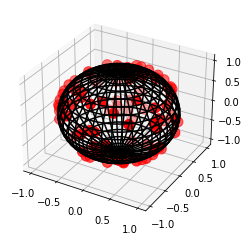

In [4]:
# Random points on a sphere surface
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

xi, yi, zi = sample_spherical(100)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect': 'auto'})
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10);

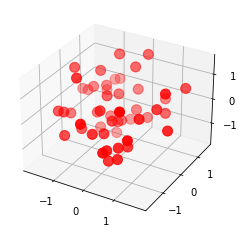

In [5]:
# Random points within a sphere
rng = np.random.default_rng()
n = 50
R = 2

phi = rng.uniform(0, 2 * np.pi, n)
costheta = rng.uniform(-np.cos(INCIDENCE_ANGLE), np.cos(INCIDENCE_ANGLE), n)
u = rng.uniform(0, 1, n)

theta = np.arccos(costheta)
r = R * np.cbrt(u)

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

an = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect': 'auto'})
ax.scatter(x, y, z, s=100, c='r', zorder=10);

In [6]:
import numpy as np
from numpy.linalg import norm
from Viewpoints import load_mesh, TANK
from scipy.spatial.transform import Rotation as R

In [7]:
# Load Object model
mesh_model, facets, incidence_normals, mesh_centers, n = load_mesh(TANK)
incidence_angle=np.pi/6; dmin=.1; dmax=2
unit_norm = mesh_model.normals / norm(mesh_model.normals, axis=1)[:, None]


In [8]:
# Generate random point within a box
# Generate 500 points randomly within a cone
mu = 500  # number of points 
cone_points = np.zeros((N, 3))
rng = np.random.default_rng()
width = np.tan(incidence_angle) * dmax
center = np.array((0, 0, 1))
i = 0

while i < N:
    z = rng.uniform(dmin, dmax)
    x, y = rng.uniform(-width, width, 2)
    point = np.array((x, y, z))
    # Check if point is within incidence cone
    theta = np.arccos(np.dot(center, point) / np.linalg.norm(point))
    if theta < incidence_angle:
        # add to cone_points
        cone_points[i] = point
        i = i + 1

In [9]:
# For all points in the mesh calculate a rectangular region to sample points from
for points, normal in zip(mesh_model.points, unit_norm):
    pass  # TODO
    

In [10]:
points = mesh_model.points.reshape(-1, 3)
p = points[0]
normal = unit_norm[0]
print(p, normal)

[1.133885 0.125    0.25    ] [ 0.  0. -1.]


In [11]:
# Cross product of z = [0,0,1] with unit normal for this point will give axis of rotation
z = np.array((0, 0, 1))
dir = np.dot(z, normal)
theta = np.arccos(dir)
rot_vec = np.cross(z, normal)

if norm(rot_vec) == 0:  # case for 0 cross product, set rotation axis as x-axis
    rot_vec = np.array((1, 0, 0))
rot_vec = rot_vec / norm(rot_vec) * theta
rotation = R.from_rotvec(rot_vec)
rotated_cone_points = rotation.apply(cone_points)

In [12]:
# Assert all rotated points are within 30deg of facet normal
r_unit_dir = rotated_cone_points / norm(rotated_cone_points, axis=1)[:, np.newaxis]
dot_r = np.dot(r_unit_dir, normal)
assert(np.all(np.arccos(dot_r) * 180 / np.pi < 30))

In [13]:
# Now we have a set of viewpoints that are all in the visible space for this facet point.
# From each viewpoint, calculate the number of points this viewpoint can see
# TODO: for each viewpoint in rotated_cone_points
viewpoint = rotated_cone_points[0]
viewpoint_dir = p - viewpoint
viewpoint_dir = viewpoint_dir / norm(viewpoint_dir)

# Filter points within viewpoint field of View
fov_angle = np.pi / 4  # 90deg field of view
view_vectors = mesh_model.points.reshape(-1, 3) - viewpoint
view_vectors = view_vectors / norm(view_vectors, axis=1)[:, np.newaxis]
fov_theta = np.arccos(np.dot(view_vectors, viewpoint_dir))
fov_visible = fov_theta < fov_angle

# Filter points pointed towards viewpoint
incidence_theta = np.arccos(np.dot(unit_norm, viewpoint_dir))
incidence_visible = incidence_theta < incidence_angle
incidence_visible = np.array([val for val in incidence_visible for _ in range(3)])  # need to expand this to match fov_visible shape

visible_points = fov_visible.shape and incidence_visible
visible_point_indices = np.argwhere(visible_points).squeeze()
# TODO: ray-tracing to determine if there's a facet in front of this line of sight
# TODO: add other constraints on the viewpoint location like height

In [14]:
# For this viewpoint, store the number of visible points and their indices  
# TODO: initialize this somewhere logical, iterate through all randomly sampled viewpoints
viewpoint_visible_point_indices = [None] * N  # an adjacency list whose index correspond to rotated_cone_points
viewpoint_visible_point_count = np.zeros(N)

viewpoint_visible_point_indices[0] = visible_point_indices
viewpoint_visible_point_count[0] = visible_point_indices.shape[0]
# Document the number of unique points seen so far
points_viewed = np.zeros()

In [18]:
a = np.arange(3)
b = np.arange(3)
np.concatenate((a, b))

array([0, 1, 2, 0, 1, 2])